aperfi is a module for apercal (in third_party) designed by Filippo Maccagni for examing RFI in Apertif data
<br>
<br>
Up-to-date versions of the modules can be found at: https://github.com/Fil8/Apertif_modules and can be installed locally with `git clone https://github.com/Fil8/Apertif_modules.git`
<br><br>
`aperfi_class.py` and `setinit_an.py` should then be copied into the `third_party` folder in your apercal directory.
<br><br>
This is a notebook by Betsey Adams as a tutorial for the functionality and how to use Aperfi.
<br><br>
This notebook should be run on happili-05 (test data is there).
<br> <br>
This notebook is updated 3 May 2018, basedon the script `aperfi_script.py` found in the git repository.


In [1]:
#First, load the needed packages
from third_party.aperfi_class import aperfi_class as aperfi
import sys, os
import aplpy
import matplotlib.pyplot as plt

#No need to set up a log (as in apercal) because nothing is reported to logger

/home/apercal/pipeline/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
/home/apercal/pipeline/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Setup logger with lib.setup_logger()


In [2]:
#load the configuration file and check it
filename = '/home/adams/apertif/RFI/rfi.cfga'
arfi = aperfi(filename) #Call this arfi so can rerun as needed (don't overwrite aperfi as module)
arfi.show()

RFI
	aperfi_uvaver = True
	aperfi_badant = []
	aperfi_rmsclip = 5
	aperfi_rfifree_min = 1422000000.0
	aperfi_rfifree_max = 1430000000.0


In [3]:
#Check that working directory is set properly in config file:
print arfi.rfidir

/data/adams/apertif/busydays/RFI/B000/rfi/


In [4]:
#This loads the important things from measurement set
#From class documentation:
"""
Loads important columns from MS file
		From MS: 
		Field_ID, Data, Flag, Antenna1, Antenna2,
		From MS/ANTENNA:
		Position,Name
		From MS/SPECTRAL_WINDOW
		Chan_width, Chan_freq
"""
arfi.load_from_ms()

Successful readonly open of default-locked table /data/adams/apertif/busydays/RFI/B000/raw/WSRTA180309008_B000.MS: 23 columns, 15510 rows
Successful readonly open of default-locked table /data/adams/apertif/busydays/RFI/B000/raw/WSRTA180309008_B000.MS/ANTENNA: 8 columns, 11 rows
	Total number of antennas	:11
	Antenna names	[ 0  1  2  3  4  5  6  7  8  9 10]
Successful readonly open of default-locked table /data/adams/apertif/busydays/RFI/B000/raw/WSRTA180309008_B000.MS/SPECTRAL_WINDOW: 14 columns, 1 rows
	Bandwidth [kHz]	:12.20703125
	Start Frequency [GHz]	:1.306640625
	End Frequency [GHz]	:1.44100341796875


In [5]:
#This gets baseline information
#From class documentation:
"""
		Reads which baselines were used in the observations
		Stores them sorted by lenght in the array baselines_sort
		Creates the Matrix to analize visibilites on each baseline separately
"""

#Note that quotes for badant parameter are very important!
#arfi.aperfi_badant = '[4]'
#arfi.aperfi_badant='[]'

arfi.baselines_from_ms()

#the reported output is a matrix of baselines where the number is the index from
#the length sorting

[[ 0  4 15 23 30 33 38 42 43 44 54]
 [ 4  0  9 17 24 29 35 39 40 41 53]
 [15  9  0  7 14 21 27 34 36 37 52]
 [23 17  7  0  5 12 20 28 31 32 51]
 [30 24 14  5  0  3 13 22 25 26 50]
 [33 29 21 12  3  0  6 16 18 19 49]
 [38 35 27 20 13  6  0  8 10 11 48]
 [42 39 34 28 22 16  8  0  0  2 47]
 [43 40 36 31 25 18 10  0  0  1 46]
 [44 41 37 32 26 19 11  2  1  0 45]
 [54 53 52 51 50 49 48 47 46 45  0]]


In [6]:
#This applies known flags
#From class documentation:
'''

		Flags YY,XY,YX polarizations
		Flags autocorrelations
		Flags bad antennas set by aperfi_badant = [ x, y, z ]
		Stores them sorted by lenght in the array baselines_sort

'''
    
arfi.priors_flag()

In [15]:
#Find the rfi, so that it can be flagged
#this is task rfi_flag
#This identifies the rfi by finding everything above a 5sigma level
#The important part is that the RFI free region of the spectrum to
#use as a reference is defined manually in the configuration file
#This does not smooth spectrally at the moment
'''

		For each baseline finds all signal above rms*aperfi_clip
		Creates a cube of visibilities sorted by baseline_lengh , frequency, time
		Stores them sorted by lenght in the array baselines_sort
		Creates the Matrix to analize visibilites on each baseline separately
'''

arfi.find_rfi()

#this does not currently work --> appears to be an issue with writing a file out?

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [9]:
#now apply the flags - this is because not sure how other steps work
#So this creates a new dataset with flags applied
#Would like to test and find out if this is really necessary, or is the flag table created enough?

'''
		Creates a new MS file where RFI has been flagged in the FLAG column
'''

arfi.rfi_flag()

#this also does not work

NameError: global name 'mean_array' is not defined

In [10]:
#Now set up a command line to wsclean to produce a dirty beam image

print arfi.rfifile

output_path = arfi.basedir+arfi.beam +'/'
print output_path

output_file = output_path+'psfonly'

command = ('''wsclean -name '''+
            output_file+
           ''' -mem 100 -no-dirty -weight natural '''+
           '''-super-weight 1.0 -weighting-rank-filter-size 16 -size 1024 1024 '''+
           '''-scale 2.6asec -channels-out 1 -grid-mode kb -kernel-size 7 '''+ 
           '''-oversampling 63 -make-psf-only -pol xx -intervals-out 1 '''+
           '''-data-column DATA -gain 0.1 -mgain 1.0 '''+
           '''-multiscale-scale-bias 0.6 -fit-beam -no-fit-beam '''
           +arfi.rfifile)

#Check that the command is reasonably formatted
print command


/data/adams/apertif/busydays/RFI/B000/rfi/rfi_flagged_vis.MS
/data/adams/apertif/busydays/RFI/B000/
wsclean -name /data/adams/apertif/busydays/RFI/B000/psfonly -mem 100 -no-dirty -weight natural -super-weight 1.0 -weighting-rank-filter-size 16 -size 1024 1024 -scale 2.6asec -channels-out 1 -grid-mode kb -kernel-size 7 -oversampling 63 -make-psf-only -pol xx -intervals-out 1 -data-column DATA -gain 0.1 -mgain 1.0 -multiscale-scale-bias 0.6 -fit-beam -no-fit-beam /data/adams/apertif/busydays/RFI/B000/rfi/rfi_flagged_vis.MS


In [11]:
#Now run the command and hope output ends up in right place!
os.system(command)

0

In [12]:
#Follow-up on to-do and make a beam without flagging
#But note that I'm not flagging currently
#so this is not super useful...

print arfi.msfile
#this is the orignal ms set, no flags applied

output_path = arfi.basedir+arfi.beam +'/'
print output_path

output_file_noflags = output_path+'psfonly_noflags'

command = ('''wsclean -name '''+
            output_file_noflags+
           ''' -mem 100 -no-dirty -weight natural '''+
           '''-super-weight 1.0 -weighting-rank-filter-size 16 -size 1024 1024 '''+
           '''-scale 2.6asec -channels-out 1 -grid-mode kb -kernel-size 7 '''+ 
           '''-oversampling 63 -make-psf-only -pol xx -intervals-out 1 '''+
           '''-data-column DATA -gain 0.1 -mgain 1.0 '''+
           '''-multiscale-scale-bias 0.6 -fit-beam -no-fit-beam '''
           +arfi.rfifile)

#Check that the command is reasonably formatted
print command

/data/adams/apertif/busydays/RFI/B000/raw/WSRTA180309008_B000.MS
/data/adams/apertif/busydays/RFI/B000/
wsclean -name /data/adams/apertif/busydays/RFI/B000/psfonly_noflags -mem 100 -no-dirty -weight natural -super-weight 1.0 -weighting-rank-filter-size 16 -size 1024 1024 -scale 2.6asec -channels-out 1 -grid-mode kb -kernel-size 7 -oversampling 63 -make-psf-only -pol xx -intervals-out 1 -data-column DATA -gain 0.1 -mgain 1.0 -multiscale-scale-bias 0.6 -fit-beam -no-fit-beam /data/adams/apertif/busydays/RFI/B000/rfi/rfi_flagged_vis.MS


In [13]:
#Now run the command and hope output ends up in right place!
os.system(command)

0

INFO: Setting slices=[0, 0] [aplpy.core]


/home/apercal/pipeline/local/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:


INFO: Auto-setting vmin to -1.194e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.085e-01 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.194e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.085e-01 [aplpy.core]


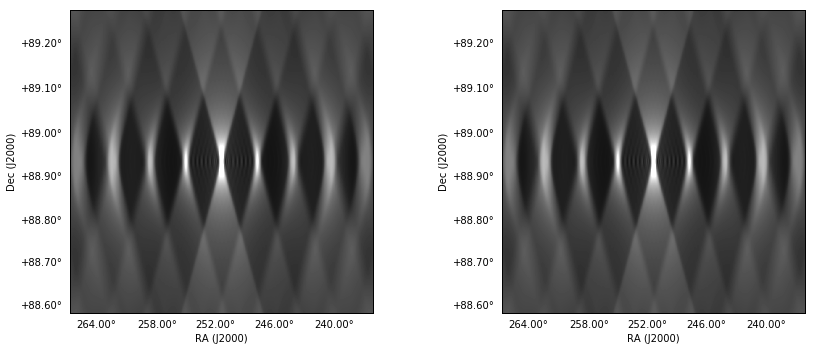

In [14]:
#And now make a figure comparing the two beams
#This will show nothing in this case, since no flagging was done

noflags = output_file_noflags+'-psf.fits'
flags = output_file+'-psf.fits'

fig=plt.figure(figsize=(12,6))

f1=aplpy.FITSFigure(noflags,figure=fig,aspect='equal',subplot=[0.1,0.15,0.35,0.7])
f1.show_grayscale()
f1.tick_labels.set_yformat('ddd.dd')
f1.tick_labels.set_xformat('ddd.dd')

f2=aplpy.FITSFigure(flags,figure=fig,aspect='equal',subplot=[0.6,0.15,0.35,0.7])
f2.show_grayscale()
f2.tick_labels.set_yformat('ddd.dd')
f2.tick_labels.set_xformat('ddd.dd')

In [ ]:
#Now look at the capabilities for plots of RFI

In [ ]:
"""To add to tutorial:
Compute beam with and without flagging and do a comparison
Also the nice plots (but need info from Filippo)"""